<a href="https://colab.research.google.com/github/melemus/rise_environment/blob/main/ReinforcementLearning/UpdatedQL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
  !pip install utils

In [ ]:
import gym
import utils
import sys
from gym import spaces
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

In [ ]:
# df = pd.read_excel('CleanedData.xlsx')
dfTrain = pd.read_excel('TrainingData.xlsx')
dfTest = pd.read_excel('TestData.xlsx')
# df = pd.read_excel('FinalData.xlsx')
# scaler = RobustScaler()
# df['Zoom'] = scaler.fit_transform(df[['Zoom']])
# def change_zoom(zoom_val):
#   if zoom_val == 7000:
#     return 1
#   elif zoom_val == 8000:
#     return 8/7
#   elif zoom_val == 13000:
#     return 13/7
#   elif zoom_val == 25000:
#     return 25/7
#   elif zoom_val == 50000:
#     return 50/7
#   return 2

# df['Zoom'] = df['Zoom'].apply(change_zoom)

# df.head()
# len(df)

In [ ]:
num_episodes = 1000
learning_rate = 0.0001
discount_factor = 0.999
exploration_prob = 0.1
num_states = 5
num_actions = 3
Q_table = np.zeros((num_states, num_actions))

zoom_actions, focus_actions, contrast_actions = [], [], []

class ImageEnv(gym.Env):
  def __init__(self, state):
    self.state = state
    self.action_space = [0, 1, 2]

  def step(self, action):
    zoom = self.state['Zoom']
    focus = self.state['Focus']
    contrast = self.state['Contrast']
    #Updated Reward Based on Ideal Values
    reward = 0
    if 1.9964*0.95 <= self.state['Average_Thickness'] <= 1.9964*1.05:
        reward += 100
    else:
        reward -= 0.8
    if 2.4233*0.95 <= self.state['Average_Separation'] <= 2.4233*1.05:
        reward+=100
    else:
        reward-=0.8

    if 14.86 <= self.state['Edge_Coverage'] <= 16.42:
        reward += 100
    else:
        reward-=1

    if 9425.9 <= self.state['Orientation_Loss'] <= 10418.1:
        reward += 100
    else:
        reward-=1
    if 4.1677*0.95 <= self.state['Distance_Entropy'] <= 4.1677*1.05:
        reward+=100
    else:
        reward-=1

    next_state = self.state

    return next_state, reward

  def reset(self):
    return self.state





In [ ]:
def discretize_state(state, num_states):
  discrete_state = [int(s * num_states) for s in state]
  return [min(max(ds, 0), num_states - 1) for ds in discrete_state]


mZ, mF, mC = [], [], []

for episode in range(num_episodes):
    state = dfTrain.iloc[np.random.randint(len(dfTrain))]
    env = ImageEnv(state)

    z_sum, f_sum, c_sum = 0, 0, 0
    for _ in range(10):
        state_value = discretize_state(state, num_states)

        if np.random.uniform(0, 1) < exploration_prob:
            action = np.random.choice(num_actions)
        else:
            action = np.argmax(Q_table[state_value])

        z_sum += state['Zoom']
        f_sum += state['Focus']
        c_sum += state['Contrast']

        next_state, reward = env.step(action)
        next_state_value = discretize_state(next_state, num_states)

        original_zoom = state['Zoom']
        original_focus = state['Focus']
        original_contrast = state['Contrast']

        calculated_zoom = next_state['Zoom']
        calculated_focus = next_state['Focus']
        calculated_contrast = next_state['Contrast']

        if abs((calculated_zoom - original_zoom) / original_zoom) > 0.05 or \
            abs((calculated_focus - original_focus) / original_focus) > 0.05 or \
            abs((calculated_contrast - original_contrast) / original_contrast) > 0.05:
            reward -= 2

        # Typical Bellman's equation
        td_target = reward + discount_factor * np.max(Q_table[next_state_value])
        td_error = td_target - Q_table[state_value, action]
        Q_table[state_value, action] += learning_rate * td_error

        state = next_state

    # Append the calculated means for this episode
    mZ.append(z_sum / 10)
    mF.append(f_sum / 10)
    mC.append(c_sum / 10)




In [ ]:

zoom_df,focus_df,contrast_df = [],[],[]
for i in range(0,len(dfTest)*4,4):
  zoom_df.append(np.median(mZ[i:i+4]))
  focus_df.append(np.mean(mF[i:i+4]))
  contrast_df.append(np.mean(mC[i:i+4]))


df_new = dfTest.assign(New_Zoom=zoom_df,New_Focus=focus_df,New_Contrast=contrast_df)
df_new.head()




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Orientation_Loss,Edge_Coverage,Average_Thickness,Average_Separation,Distance_Entropy,Zoom,Focus,Contrast,New_Zoom,New_Focus,New_Contrast
0,248.022858,21.454239,1.587279,1.890422,0.990103,25000,8.0,66.5874,50000.0,7.125,69.163450
1,232.665863,21.107864,1.617346,1.807144,0.995191,25000,7.9,66.5874,37500.0,7.150,68.800600
2,160.153534,18.979645,1.854154,2.025063,0.998723,25000,8.0,63.1759,75000.0,7.175,69.323625
3,265.774322,21.216393,1.590409,1.826176,0.993054,25000,7.4,67.1546,50000.0,7.575,67.324525
4,198.644211,22.973633,1.587109,1.714505,0.997697,25000,7.9,66.5874,50000.0,7.200,68.305350


In [ ]:
df_new['Zoom_diff'] = df_new['Zoom']-df_new['New_Zoom']
df_new['Contrast_diff'] = df_new['Contrast']-df_new['New_Contrast']
df_new['Focus_diff'] = df_new['Focus']-df_new['New_Focus']
df_new.head()



,Orientation_Loss,Edge_Coverage,Average_Thickness,Average_Separation,Distance_Entropy,Zoom,Focus,Contrast,New_Zoom,New_Focus,New_Contrast,Zoom_diff,Contrast_diff,Focus_diff
0,248.022858,21.454239,1.587279,1.890422,0.990103,25000,8.0,66.5874,50000.0,7.125,69.163450,-25000.0,-2.576050,0.875
1,232.665863,21.107864,1.617346,1.807144,0.995191,25000,7.9,66.5874,37500.0,7.150,68.800600,-12500.0,-2.213200,0.750
2,160.153534,18.979645,1.854154,2.025063,0.998723,25000,8.0,63.1759,75000.0,7.175,69.323625,-50000.0,-6.147725,0.825
3,265.774322,21.216393,1.590409,1.826176,0.993054,25000,7.4,67.1546,50000.0,7.575,67.324525,-25000.0,-0.169925,-0.175
4,198.644211,22.973633,1.587109,1.714505,0.997697,25000,7.9,66.5874,50000.0,7.200,68.305350,-25000.0,-1.717950,0.700


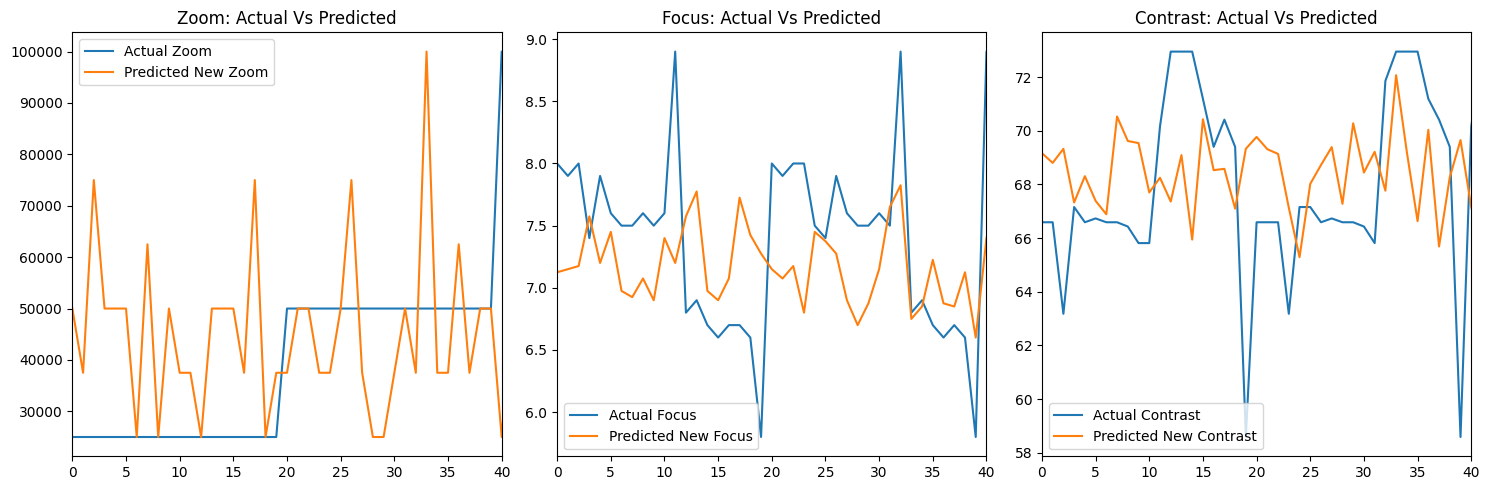

In [ ]:


original_zoom = df_new['Zoom']
original_focus = df_new['Focus']
original_contrast = df_new['Contrast']

predicted_new_zoom = df_new['New_Zoom']
predicted_new_focus = df_new['New_Focus']
predicted_new_contrast = df_new['New_Contrast']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.subplots_adjust(wspace=0.3)
axes[0].plot(original_zoom, label='Actual Zoom')
axes[0].plot(predicted_new_zoom, label='Predicted New Zoom')
axes[0].set_title('Zoom: Actual Vs Predicted')
axes[0].legend()
axes[0].set_xlim([0, 40])

axes[1].plot(original_focus, label='Actual Focus')
axes[1].plot(predicted_new_focus, label='Predicted New Focus')
axes[1].set_title('Focus: Actual Vs Predicted')
axes[1].legend()
axes[1].set_xlim([0, 40])

axes[2].plot(original_contrast, label='Actual Contrast')
axes[2].plot(predicted_new_contrast, label='Predicted New Contrast')
axes[2].set_title('Contrast: Actual Vs Predicted')
axes[2].legend()
axes[2].set_xlim([0, 40])

plt.tight_layout()
plt.show()


# PLOTTING AND TESTING

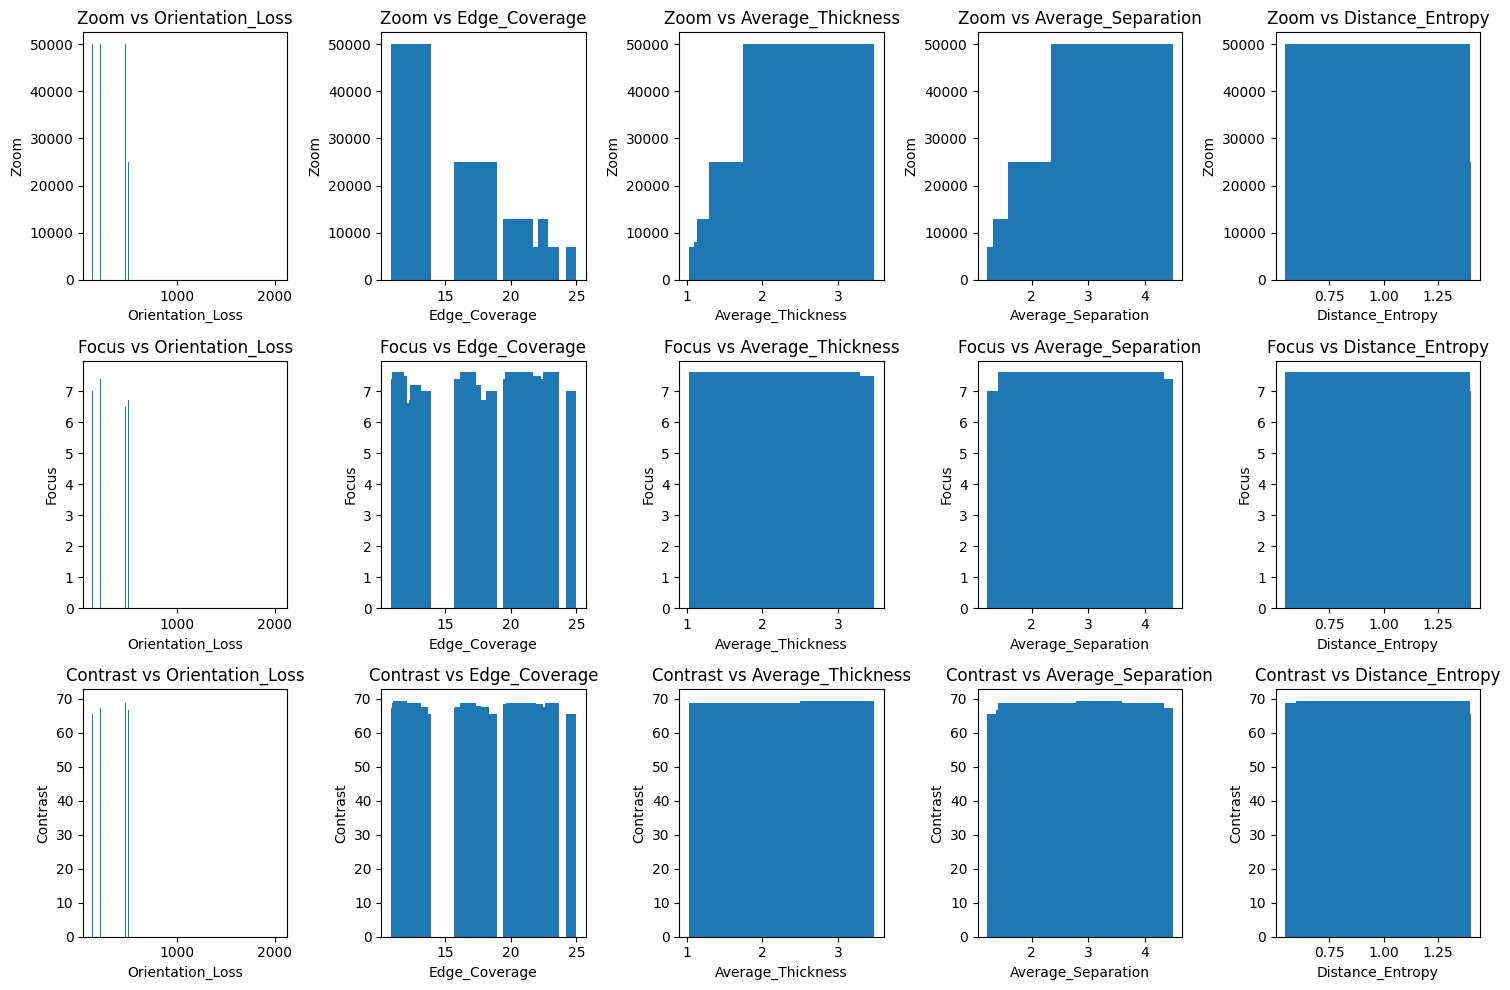

In [ ]:
params = ['Orientation_Loss', 'Edge_Coverage', 'Average_Thickness', 'Average_Separation', 'Distance_Entropy']
actions = ['Zoom', 'Focus', 'Contrast']


fig, axes = plt.subplots(len(actions), len(params), figsize=(15, 10))
fig.subplots_adjust(wspace=0.3, hspace=0.3)  # Adjust spacing between subplots


for i, action in enumerate(actions):
    for j, param in enumerate(params):
        ax = axes[i, j]
        ax.bar(df[param], df[action])
        ax.set_xlabel(param)
        ax.set_ylabel(action)
        ax.set_title(f'{action} vs {param}')

plt.tight_layout()
plt.show()


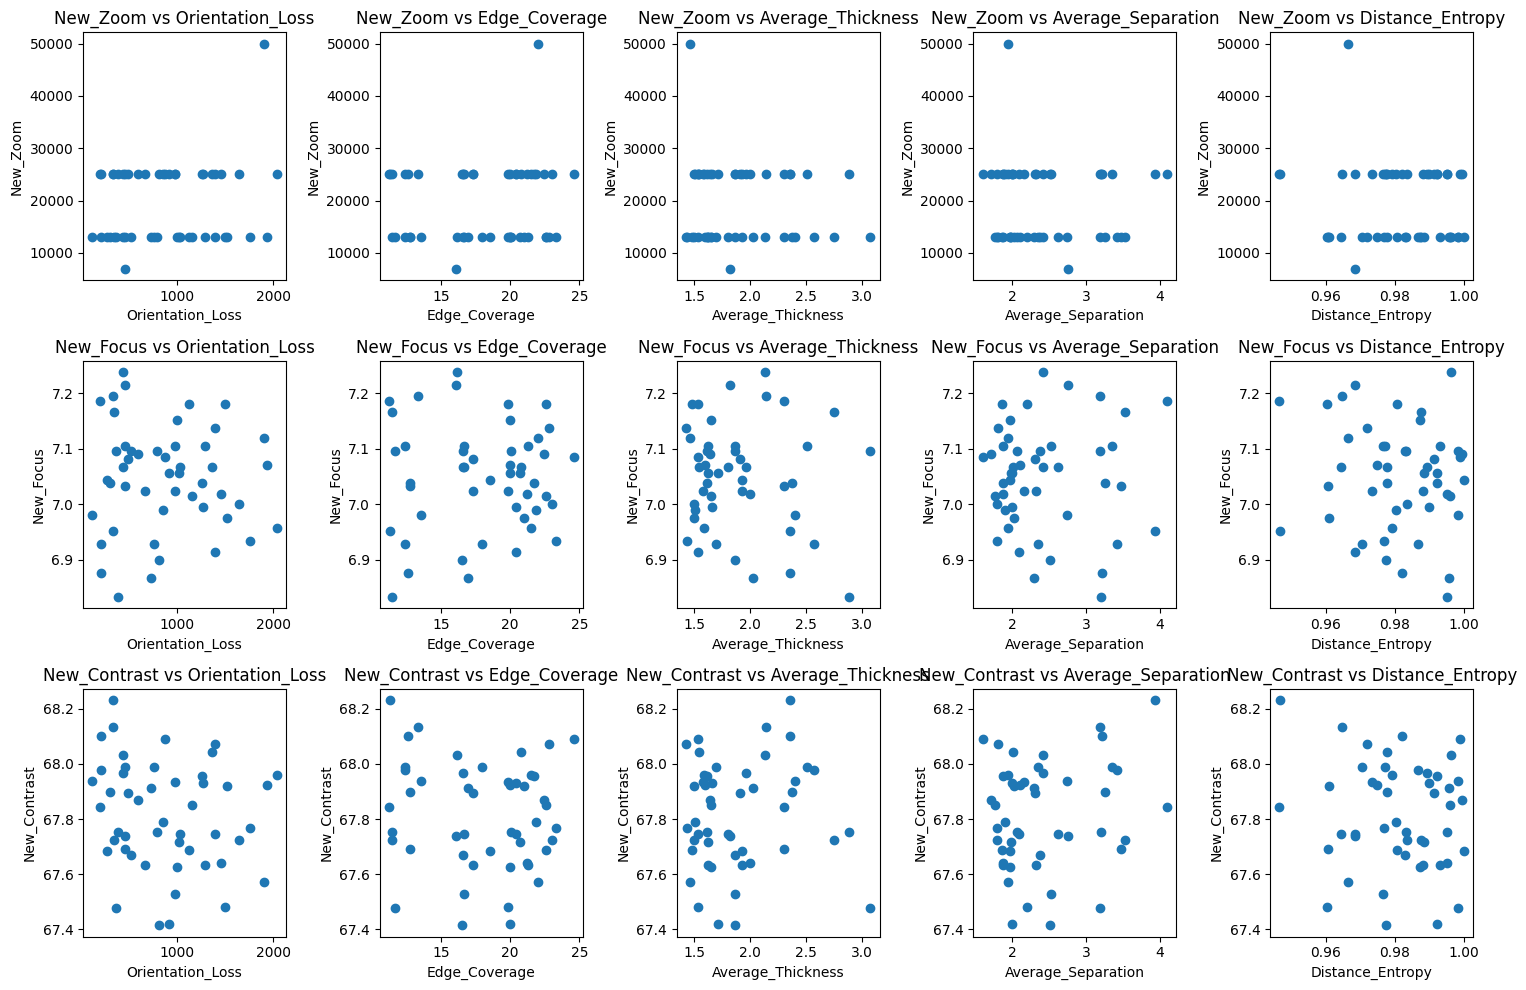

In [ ]:
params = ['Orientation_Loss', 'Edge_Coverage', 'Average_Thickness', 'Average_Separation', 'Distance_Entropy']
actions = ['New_Zoom', 'New_Focus', 'New_Contrast']


fig, axes = plt.subplots(len(actions), len(params), figsize=(15, 10))
fig.subplots_adjust(wspace=0.3, hspace=0.3)  # Adjust spacing between subplots


for i, action in enumerate(actions):
    for j, param in enumerate(params):
        ax = axes[i, j]
        ax.scatter(df_new[param], df_new[action])
        ax.set_xlabel(param)
        ax.set_ylabel(action)
        ax.set_title(f'{action} vs {param}')

plt.tight_layout()
plt.show()


In [ ]:
from google.colab import drive
drive.mount('drive')
df_new.to_csv('/content/UpdatedData.csv',index=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/pexpect/popen_spawn.py:60: DeprecationWarning: setDaemon() is deprecated, set the daemon attribute instead
  self._read_thread.setDaemon(True)


Mounted at drive


DONT RUN THE BELOW CELL

In [ ]:
#CHATGPT
#
param_mapping = []

for episode in range(num_episodes):
    state = df.iloc[np.random.randint(len(df))]
    env = ImageEnv(state)

    z_sum, f_sum, c_sum = 0, 0, 0
    param_mapping_episode = []

    for _ in range(10):
        state_value = discretize_state(state, num_states)

        if np.random.uniform(0, 1) < exploration_prob:
            action = np.random.choice(num_actions)
        else:
            action = np.argmax(Q_table[state_value])

        z_sum += state['Zoom']
        f_sum += state['Focus']
        c_sum += state['Contrast']

        # Store the mapping of parameters and the corresponding Zoom value
        param_mapping_episode.append({
            'Orientation_Loss': state['Orientation_Loss'],
            'Edge_Coverage': state['Edge_Coverage'],
            'Average_Thickness': state['Average_Thickness'],
            'Average_Separation': state['Average_Separation'],
            'Distance_Entropy': state['Distance_Entropy'],
            'Zoom_New': state['Zoom'],
            'Focus_New': state['Focus'],
            'Contrast_New': state['Contrast']
        })

        next_state, reward = env.step(action)
        next_state_value = discretize_state(next_state, num_states)

        # Typical Bellman's equation
        td_target = reward + discount_factor * np.max(Q_table[next_state_value])
        td_error = td_target - Q_table[state_value, action]
        Q_table[state_value, action] += learning_rate * td_error

        state = next_state

    mZ.append(z_sum / 10)
    mF.append(f_sum / 10)
    mC.append(c_sum / 10)
    param_mapping.append(param_mapping_episode)



print(len(param_mapping))


IndexError: ignored